# Dataset Preprocessing

In [1]:
# While Model training
# 1. --- Print model summary (trainable, non-trainable, total parameters) 
# 2. --- while compiling the model, add other metrics like roc_auc score, precision, recall,f1-score,specifity,sensivity,accuracy,loss (training and validation both)
# 3. --- Plot metrics curves VS epochs like mentioned in 2 
# 4. --- Plot confusion matrix like training, validation, test dataset 
# 5. --- Implement early stopping with 100 epochs
# 6. --- records total time (training, testing, validation) and also What GPU you are using it.
# 7. ---- Save the models as well ( .hdf5 format for loading the trained weights)
# 8. ---- keep similar loss functions, optimizers, learning rate, epochs, ...etc

In [2]:
!pip install keras tensorflow

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import os

from glob import glob

import seaborn as sns

from PIL import Image

np.random.seed(123)

from sklearn.preprocessing import label_binarize

from sklearn.metrics import confusion_matrix

import itertools

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding

from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from keras import backend as K

import itertools

from keras.layers import BatchNormalization

from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding



from keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

In [4]:
dataset_path = '/kaggle/input/skin-cancer-mnist-ham10000'

In [5]:
#1. Function to plot model's validation loss and validation accuracy

def plot_model_history(model_history):

    fig, axs = plt.subplots(1,2,figsize=(15,5))

    # summarize history for accuracy

    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])

    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])

    axs[0].set_title('Model Accuracy')

    axs[0].set_ylabel('Accuracy')

    axs[0].set_xlabel('Epoch')

    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)

    axs[0].legend(['train', 'val'], loc='best')

    # summarize history for loss

    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])

    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])

    axs[1].set_title('Model Loss')

    axs[1].set_ylabel('Loss')

    axs[1].set_xlabel('Epoch')

    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)

    axs[1].legend(['train', 'val'], loc='best')

    plt.show()

In [6]:
df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [8]:
df.shape

(10015, 7)

In [9]:
lesion_type_dict = {

    'nv': 'Melanocytic nevi',

    'mel': 'Melanoma',

    'bkl': 'Benign keratosis-like lesions ',

    'bcc': 'Basal cell carcinoma',

    'akiec': 'Actinic keratoses',

    'vasc': 'Vascular lesions',

    'df': 'Dermatofibroma'

}

base_skin_dir = '/kaggle/input/skin-cancer-mnist-ham10000'

In [10]:
import os

from glob import glob



# Use glob to get a list of file paths

image_paths = glob(os.path.join(base_skin_dir, '*', '*.jpg'))



# Create a dictionary mapping image IDs to file paths

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths}

In [11]:
df['path'] = df['image_id'].map(imageid_path_dict.get)

df['cell_type'] = df['dx'].map(lesion_type_dict.get)

df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes



df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2


In [12]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [13]:
df['age'].fillna((df['age'].mean()), inplace=True)

/tmp/ipykernel_23/1123070014.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna((df['age'].mean()), inplace=True)


In [14]:
df.isna().sum().sum()

0

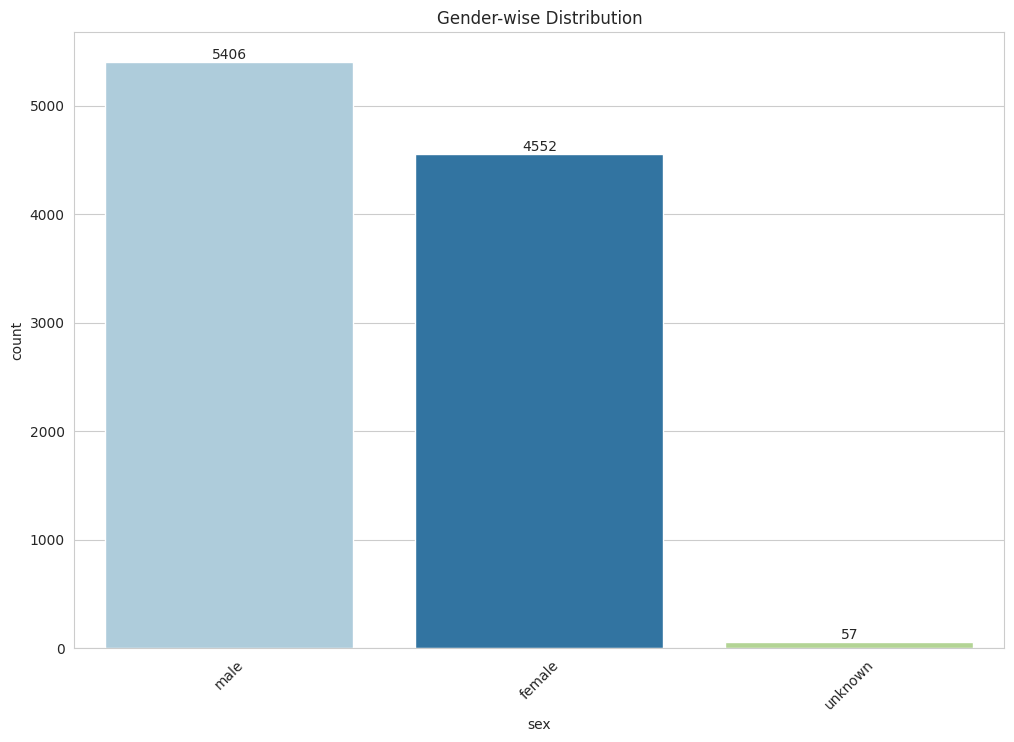

In [15]:
sns.set_style('whitegrid')

colors = ['#87ace8','#e3784d', 'green']

fig,axes = plt.subplots(figsize=(12,8))



ax = sns.countplot(x='sex',data=df, palette = 'Paired')

for container in ax.containers:

    ax.bar_label(container)

plt.title('Gender-wise Distribution')

plt.xticks(rotation=45)

plt.show()

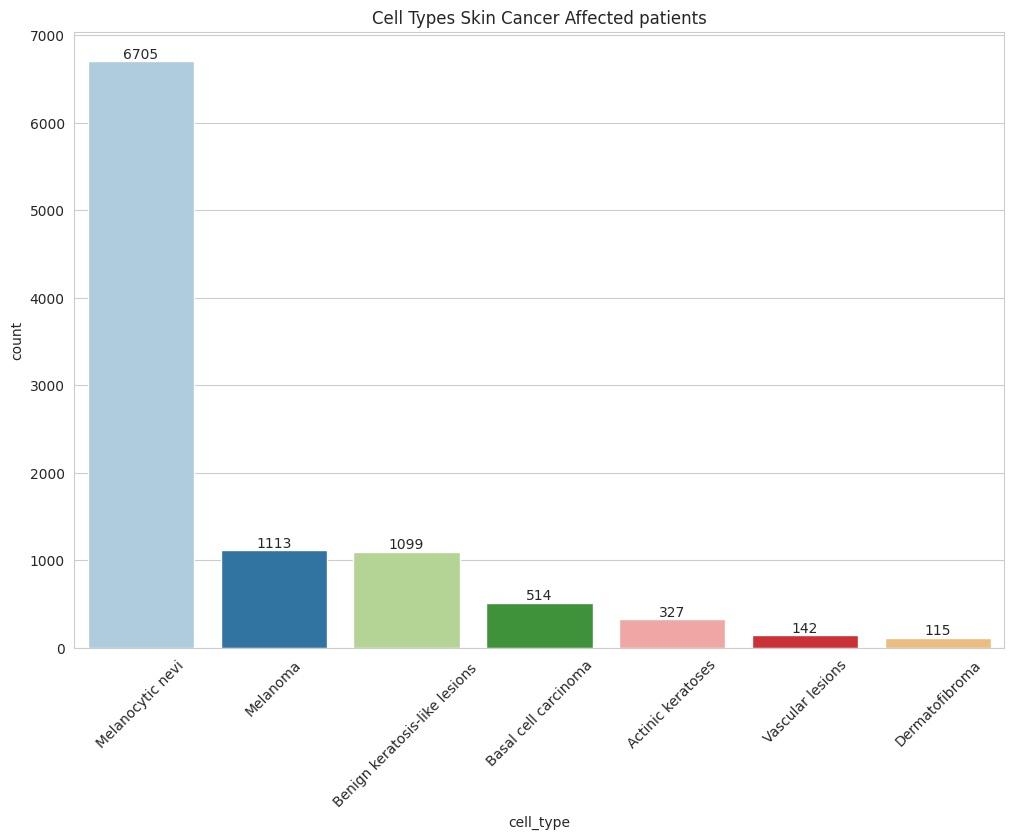

In [16]:
sns.set_style('whitegrid')

fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')

for container in ax.containers:

    ax.bar_label(container)

plt.title('Cell Types Skin Cancer Affected patients')

plt.xticks(rotation=45)

plt.show()

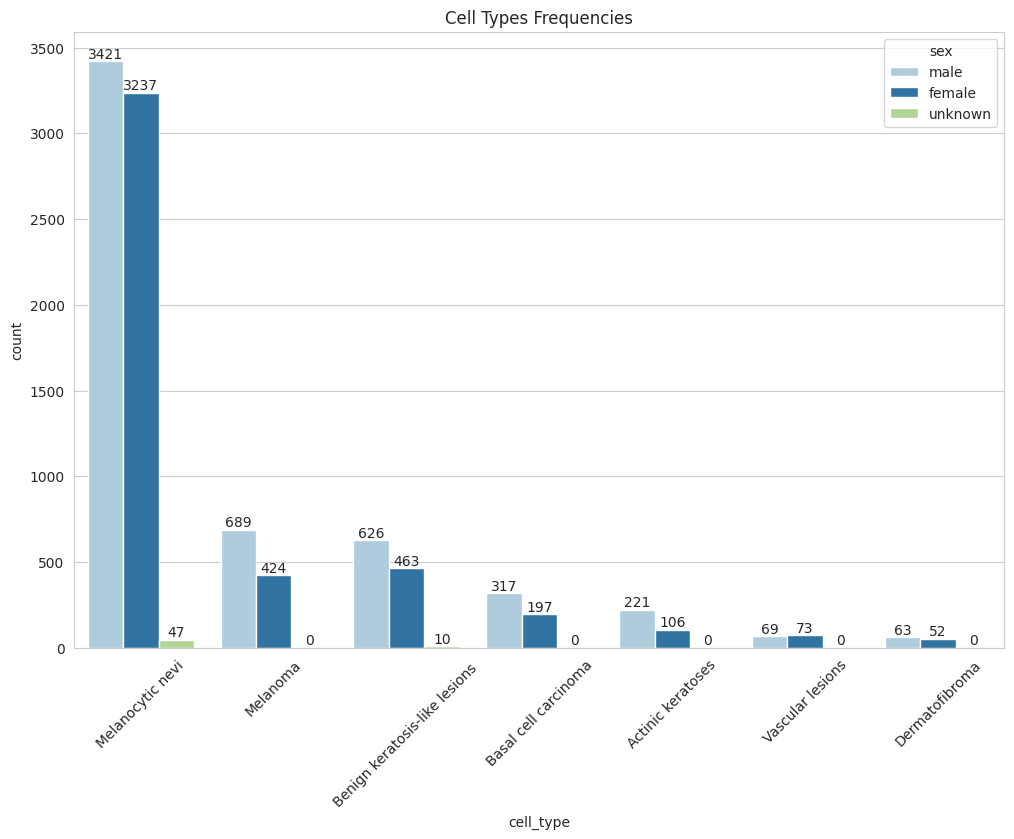

In [17]:
sns.set_style('whitegrid')

fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='cell_type',hue='sex', data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')

for container in ax.containers:

    ax.bar_label(container)

plt.title('Cell Types Frequencies')

plt.xticks(rotation=45)

plt.show()

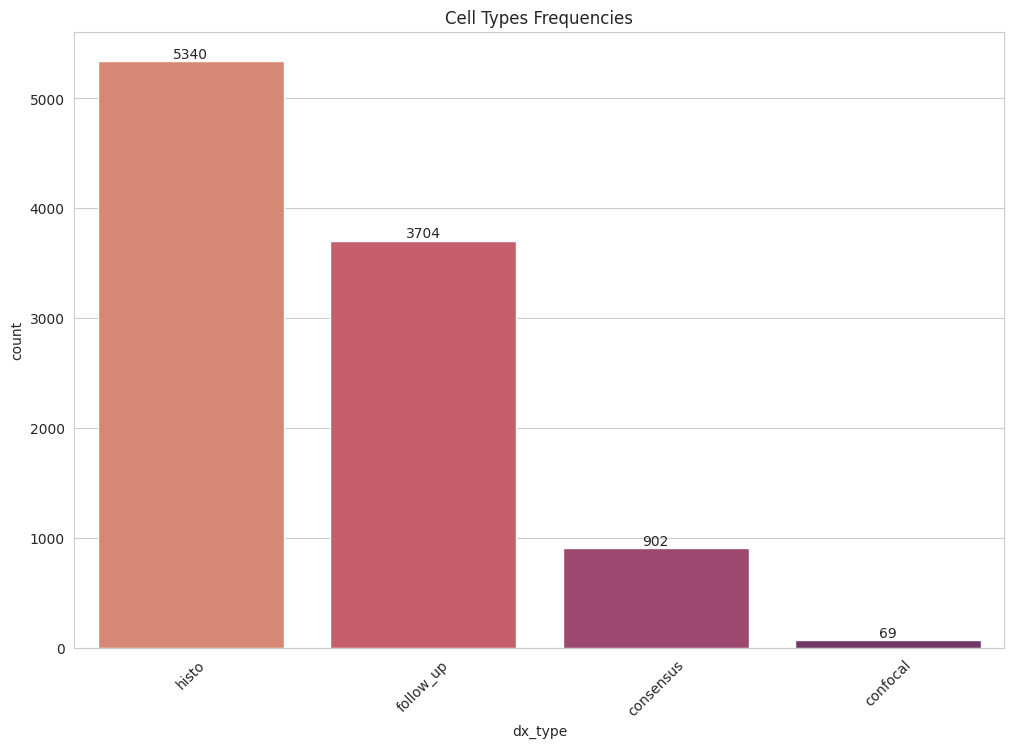

In [18]:
sns.set_style('whitegrid')

fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='dx_type',data=df, order = df['dx_type'].value_counts().index, palette = 'flare')

for container in ax.containers:

    ax.bar_label(container)

plt.title('Cell Types Frequencies')

plt.xticks(rotation=45)

plt.show()

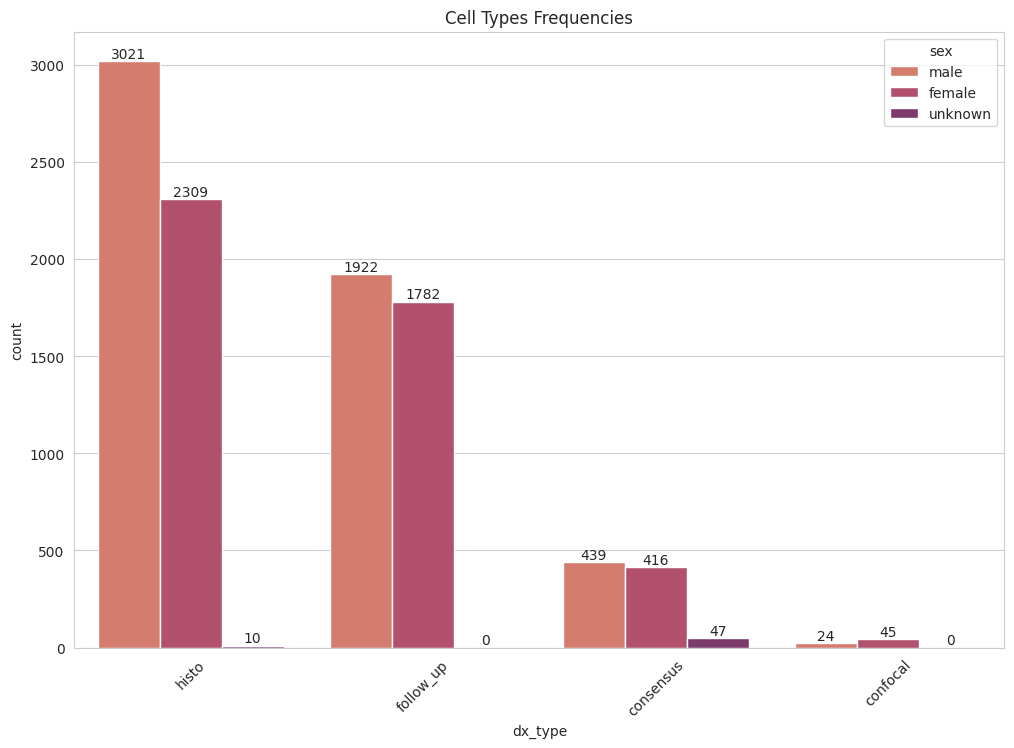

In [19]:
sns.set_style('whitegrid')

fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='dx_type',hue='sex', data=df, order = df['dx_type'].value_counts().index, palette = 'flare')

for container in ax.containers:

    ax.bar_label(container)

plt.title('Cell Types Frequencies')

plt.xticks(rotation=45)

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


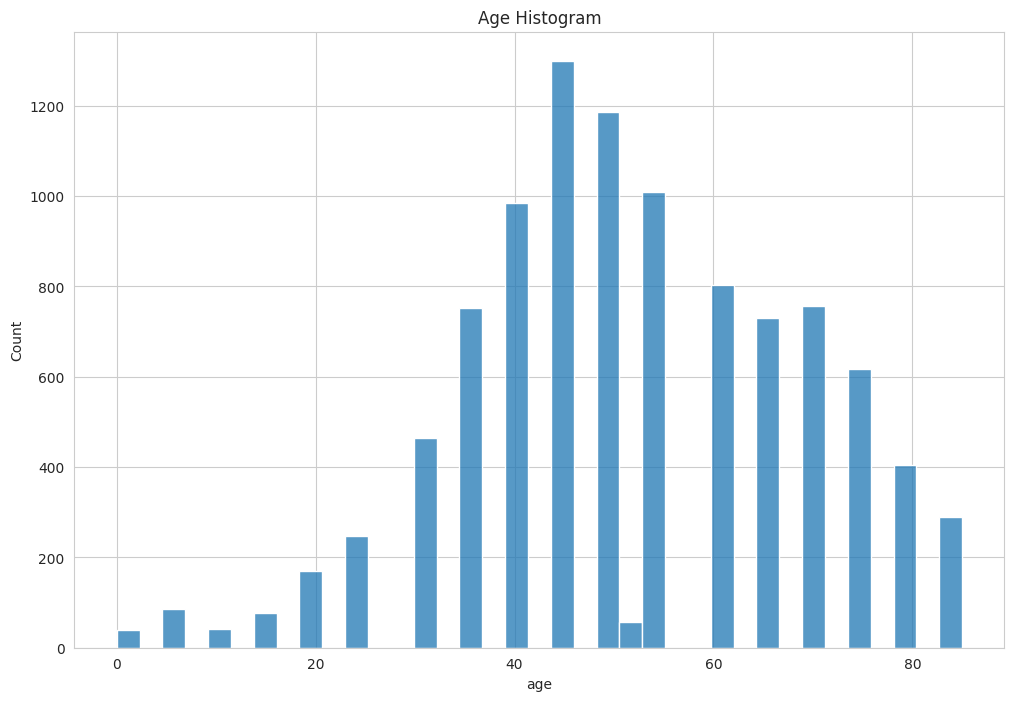

In [20]:
sns.set_style('whitegrid')

fig,axes = plt.subplots(figsize=(12,8))

ax = sns.histplot(data=df, x='age')

plt.title('Age Histogram')

plt.show()

In [21]:
size = (64, 64)

df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize(size))/ 255)

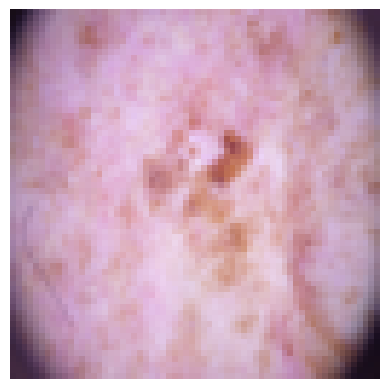

In [22]:
arr = df.iloc[1]['image']

#Image.fromarray(arr)

plt.imshow(arr)

plt.axis('off')

plt.show()

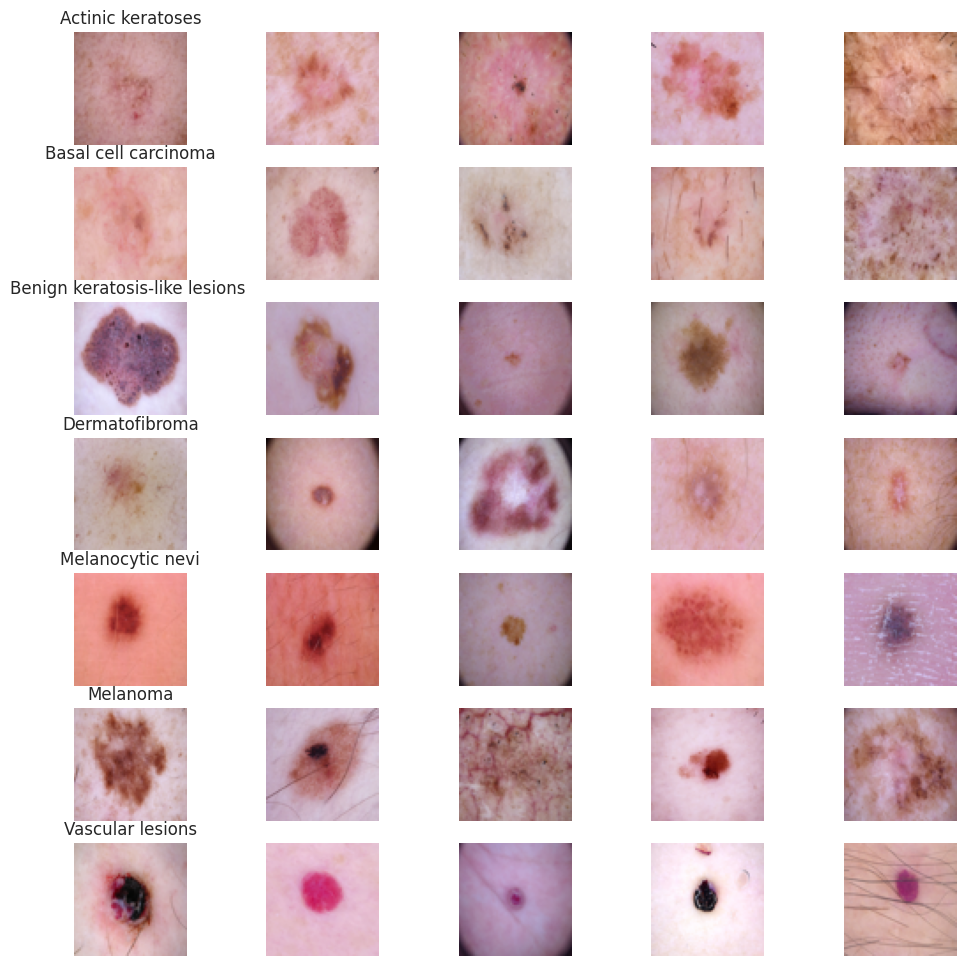

In [23]:
n_samples = 5

fig, m_axs = plt.subplots(7, n_samples, figsize = (12,12))

for n_axs, (type_name, type_rows) in zip(m_axs,

                                         df.sort_values(['cell_type']).groupby('cell_type')):

    n_axs[0].set_title(type_name)

    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):

        c_ax.imshow(c_row['image'])

        c_ax.axis('off')

# fig.savefig('category_samples.png', dpi=300)

In [24]:
df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [25]:
def aug_brightness(img_arr):

    aug_arr = tf.image.stateless_random_brightness(img_arr, 0.7, seed)

    aur_arr = np.array(aug_arr)



    return aug_arr

In [26]:
def aug_contrast(img_arr):

    aug_arr = tf.image.stateless_random_contrast(img_arr, 0.2, 0.8, seed)

    aur_arr = np.array(aug_arr)



    return aug_arr

In [27]:
def aug_flip_left_right(img_arr):

    aug_arr = tf.image.stateless_random_flip_left_right(img_arr, seed).numpy().tolist()

    aur_arr = np.array(aug_arr)



    return aug_arr

In [28]:
def aug_flip_up_down(img_arr):

    aug_arr = tf.image.stateless_random_flip_up_down(img_arr, seed).numpy().tolist()

    aur_arr = np.array(aug_arr)



    return aug_arr

In [29]:
def aug_hue(img_arr):

    aug_arr = tf.image.stateless_random_hue(img_arr, 0.5, seed)

    aur_arr = np.array(aug_arr)



    return aug_arr

In [30]:
def aug_saturation(img_arr):

    aug_arr = tf.image.stateless_random_saturation(img_arr, 0.1, 1, seed)

    aur_arr = np.array(aug_arr)



    return aug_arr

In [31]:
func_list = [aug_brightness, aug_contrast, aug_flip_left_right, aug_flip_up_down, aug_hue, aug_saturation]

In [32]:
from IPython.display import clear_output

def random_augmentation(images, dx, num_of_samples):

    new_images = []

    all_indices = []

    while (len(new_images) < num_of_samples):

        indices = np.random.randint(images.shape[0], size=6)

        r = list(map(lambda x, y: x(y), func_list, images.iloc[indices]))

        r = [np.array(tensor) for tensor in r]

        new_images.extend(r)

        all_indices.extend(indices)

        clear_output(wait=True)

        print(str(len(new_images)) + '/' + str(num_of_samples))



    new_images = pd.DataFrame({'dx': dx, 'image': new_images})



    return all_indices, new_images

In [33]:
nv_df = df[df['dx'] == 'nv']

df_df = df[df['dx'] == 'df']

vasc_df = df[df['dx'] == 'vasc']

akiec_df = df[df['dx'] == 'akiec']

bcc_df = df[df['dx'] == 'bcc']

bkl_df = df[df['dx'] == 'bkl']

mel_df = df[df['dx'] == 'mel']

In [34]:
seed = (4,2)

In [35]:
max_count = 10000

nv_count = (df['dx'] == 'nv').sum()

mel_count = (df['dx'] == 'mel').sum()

bkl_count = (df['dx'] == 'bkl').sum()

bcc_count = (df['dx'] == 'bcc').sum()

akiec_count = (df['dx'] == 'akiec').sum()

vasc_count = (df['dx'] == 'vasc').sum()

df_count = (df['dx'] == 'df').sum()

In [36]:
# df_images = df_df['image']

# df_indices, df_new_images = random_augmentation(df_images, 'df', max_count - df_count)

In [37]:
# vasc_images = vasc_df['image']

# vasc_indices, vasc_new_images = random_augmentation(vasc_images, 'vasc', max_count - vasc_count)

In [38]:
# akiec_images = akiec_df['image'] 

# akiec_indices, akiec_new_images = random_augmentation(akiec_images, 'akiec', max_count - akiec_count)

In [39]:
# bcc_images = bcc_df['image']

# bcc_indices, bcc_new_images = random_augmentation(bcc_images, 'bcc', max_count - bcc_count)

In [40]:
# bkl_images = bkl_df['image']

# bkl_indices, bkl_new_images = random_augmentation(bkl_images, 'bkl', max_count - bkl_count)

In [41]:
# mel_images = mel_df['image']

# mel_indices, mel_new_images = random_augmentation(mel_images, 'mel', max_count - mel_count)

In [42]:
# nv_images = nv_df['image']

# nv_indices, nv_new_images = random_augmentation(nv_images, 'nv', max_count - nv_count)

In [43]:
# new_images_df = pd.concat([df_new_images, vasc_new_images, akiec_new_images, bcc_new_images, bkl_new_images, mel_new_images, nv_new_images], axis=0).reset_index(drop=True)

# aug_df = pd.concat([df, new_images_df], axis=0).reset_index(drop=True)

# aug_df = aug_df.sample(frac=1).reset_index(drop=True)

In [44]:
pd.DataFrame(df['dx'].value_counts()).reset_index()

,dx,count
0,nv,6705
1,mel,1113
2,bkl,1099
3,bcc,514
4,akiec,327
5,vasc,142
6,df,115


In [45]:
#aug_df.shape

In [46]:
# for i in range(12, 18):

#     plt.subplot(1, 3, 1)

#     plt.imshow(mel_df['image'].iloc[mel_indices[i]])

#     plt.title('Original')

#     plt.axis('off')



#     plt.subplot(1, 3, 2)

#     plt.imshow(mel_new_images['image'].iloc[i])

#     plt.title('Augmented')

#     plt.axis('off')



#     plt.show()

In [47]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

df['label'] = labelEncoder.fit_transform(df['dx'])

In [48]:
x = np.asarray(df['image'].to_list())

y = to_categorical(df['label'], num_classes=7)



x_train, x_test, y_train, y_test = train_test_split(

    x, y, test_size=0.20, random_state=42, shuffle=True, stratify=y

)

# **Model setup**

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers
from keras import backend
from keras import activations, ops

In [50]:
num_classes = 7
input_shape = (64, 64, 3)
weight_decay = 0.0001
label_smoothing = 0.1
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 1024


In [51]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, x):
        B, C = ops.shape(x)[0], ops.shape(x)[-1]
        x = ops.image.extract_patches(x, self.patch_size)
        x = ops.reshape(x, (B, -1, self.patch_size * self.patch_size * C))
        return x


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch, step=1)
        return self.proj(patch) + self.pos_embed(pos)

In [52]:
def external_attention(
    x,
    dim,
    num_heads,
    dim_coefficient=4,
    attention_dropout=0,
    projection_dropout=0,
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = ops.reshape(x, (-1, num_patch, num_heads, dim * dim_coefficient // num_heads))
    x = ops.transpose(x, axes=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = layers.Lambda(
        lambda attn: ops.divide(
            attn,
            ops.convert_to_tensor(1e-9) + ops.sum(attn, axis=-1, keepdims=True),
        )
    )(attn)
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = ops.transpose(x, axes=[0, 2, 1, 3])
    x = ops.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [53]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=ops.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

In [54]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=attention_dropout,
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

In [55]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Extract patches.
    x = PatchExtract(patch_size)(inputs)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [56]:
class Perceiver(keras.Model):
    def __init__(
        self,
        patch_size,
        data_dim,
        latent_dim,
        projection_dim,
        num_heads,
        num_transformer_blocks,
        ffn_units,
        dropout_rate,
        num_iterations,
        classifier_units,
    ):
        super().__init__()

        self.latent_dim = latent_dim
        self.data_dim = data_dim
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.num_transformer_blocks = num_transformer_blocks
        self.ffn_units = ffn_units
        self.dropout_rate = dropout_rate
        self.num_iterations = num_iterations
        self.classifier_units = classifier_units

    def build(self, input_shape):
        # Create latent array.
        self.latent_array = self.add_weight(
            shape=(self.latent_dim, self.projection_dim),
            initializer="random_normal",
            trainable=True,
        )

        # Create patching module.war
        self.patch_encoder = PatchEncoder(self.data_dim, self.projection_dim)

        # Create cross-attenion module.
        self.cross_attention = create_cross_attention_module(
            self.latent_dim,
            self.data_dim,
            self.projection_dim,
            self.ffn_units,
            self.dropout_rate,
        )

        # Create Transformer module.
        self.transformer = create_transformer_module(
            self.latent_dim,
            self.projection_dim,
            self.num_heads,
            self.num_transformer_blocks,
            self.ffn_units,
            self.dropout_rate,
        )

        # Create global average pooling layer.
        self.global_average_pooling = layers.GlobalAveragePooling1D()

        # Create a classification head.
        self.classification_head = create_ffn(
            hidden_units=self.classifier_units, dropout_rate=self.dropout_rate
        )

        super().build(input_shape)

    def call(self, inputs):
        # Augment data.
        augmented = data_augmentation(inputs)
        # Create patches.
        patches = self.patch_encoder(augmented)
        # Encode patches.
        encoded_patches = self.patch_encoder(patches)
        # Prepare cross-attention inputs.
        cross_attention_inputs = {
            "latent_array": ops.expand_dims(self.latent_array, 0),
            "data_array": encoded_patches,
        }
        # Apply the cross-attention and the Transformer modules iteratively.
        for _ in range(self.num_iterations):
            # Apply cross-attention from the latent array to the data array.
            latent_array = self.cross_attention(cross_attention_inputs)
            # Apply self-attention Transformer to the latent array.
            latent_array = self.transformer(latent_array)
            # Set the latent array of the next iteration.
            cross_attention_inputs["latent_array"] = latent_array

        # Apply global average pooling to generate a [batch_size, projection_dim] repesentation tensor.
        representation = self.global_average_pooling(latent_array)
        # Generate logits.
        logits = self.classification_head(representation)
        return logits

In [57]:
EANet = get_model(attention_type="external_attention")
EANet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_extract       │ (None, None, 12)  │          0 │ input_layer[0][0] │
│ (PatchExtract)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 1024, 64)  │     66,368 │ patch_extract[0]… │
│ (PatchEmbedding)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1024, 64)  │        128 │ patch_embedding[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024, 256) │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1024, 16,  │          0 │ dense_1[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose           │ (None, 16, 1024,  │          0 │ reshape[0][0]     │
│ (Transpose)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16, 1024,  │        272 │ transpose[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 16, 1024,  │          0 │ dense_2[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 16, 1024,  │          0 │ softmax[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 1024,  │          0 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16, 1024,  │        272 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_1         │ (None, 1024, 16,  │          0 │ dense_3[0][0]     │
│ (Transpose)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1024, 256) │          0 │ transpose_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1024, 64)  │     16,448 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1024, 64)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1024, 64)  │          0 │ dropout_1[0][0],  │
│                     │                   │            │ patch_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1024, 64)  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 404,487 (1.54 MB)

 Trainable params: 404,487 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision_value = self.precision.result()
        recall_value = self.recall.result()
        return 2 * (precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [59]:
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam

# Compile the model
EANet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='roc_auc'),
        F1Score(name='f1_score')  
    ]
)

In [60]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = EANet.fit(
    x_train,  # Input data
    y_train,  # Target labels
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100


I0000 00:00:1737836957.655157      76 service.cc:145] XLA service 0x7c8194002270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737836957.655218      76 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1737837022.739998      76 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_26', 224 bytes spill stores, 224 bytes spill loads

I0000 00:00:1737837022.810260      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.6449 - f1_score: 0.6271 - loss: 1.3816 - precision: 0.6928 - recall: 0.5735 - roc_auc: 0.8611

I0000 00:00:1737837113.053863      76 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_29', 224 bytes spill stores, 224 bytes spill loads



226/226 ━━━━━━━━━━━━━━━━━━━━ 180s 422ms/step - accuracy: 0.6449 - f1_score: 0.6272 - loss: 1.3805 - precision: 0.6929 - recall: 0.5735 - roc_auc: 0.8612 - val_accuracy: 0.6022 - val_f1_score: 0.5450 - val_loss: 1.0383 - val_precision: 0.7123 - val_recall: 0.4414 - val_roc_auc: 0.9094 - learning_rate: 0.0010
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.6827 - f1_score: 0.6666 - loss: 0.9007 - precision: 0.7813 - recall: 0.5822 - roc_auc: 0.9319 - val_accuracy: 0.6596 - val_f1_score: 0.6527 - val_loss: 0.9684 - val_precision: 0.7776 - val_recall: 0.5623 - val_roc_auc: 0.9242 - learning_rate: 0.0010
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.7009 - f1_score: 0.6992 - loss: 0.8300 - precision: 0.8083 - recall: 0.6161 - roc_auc: 0.9418 - val_accuracy: 0.6534 - val_f1_score: 0.6495 - val_loss: 0.8835 - val_precision: 0.7596 - val_recall: 0.5673 - val_roc_auc: 0.9347 - learning_rate: 0.0010
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/

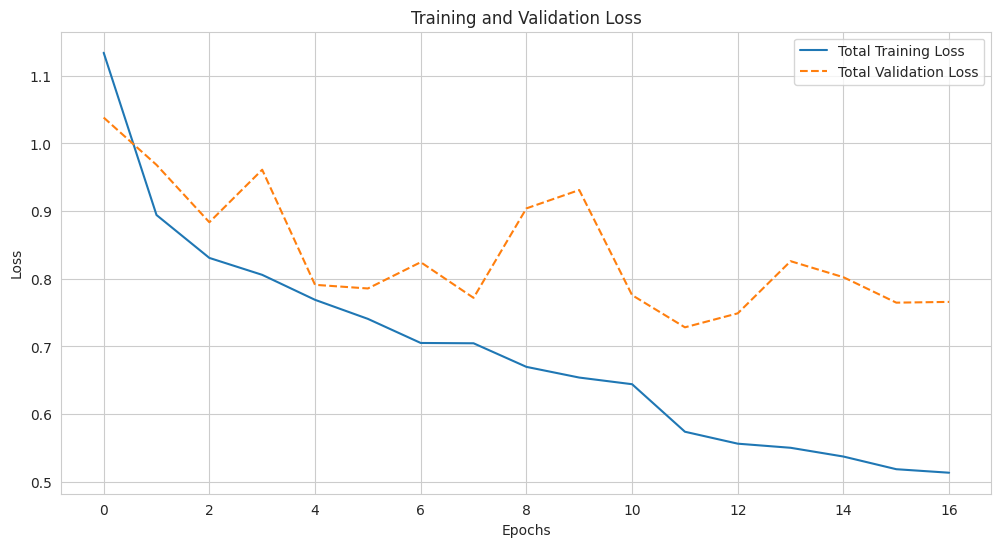

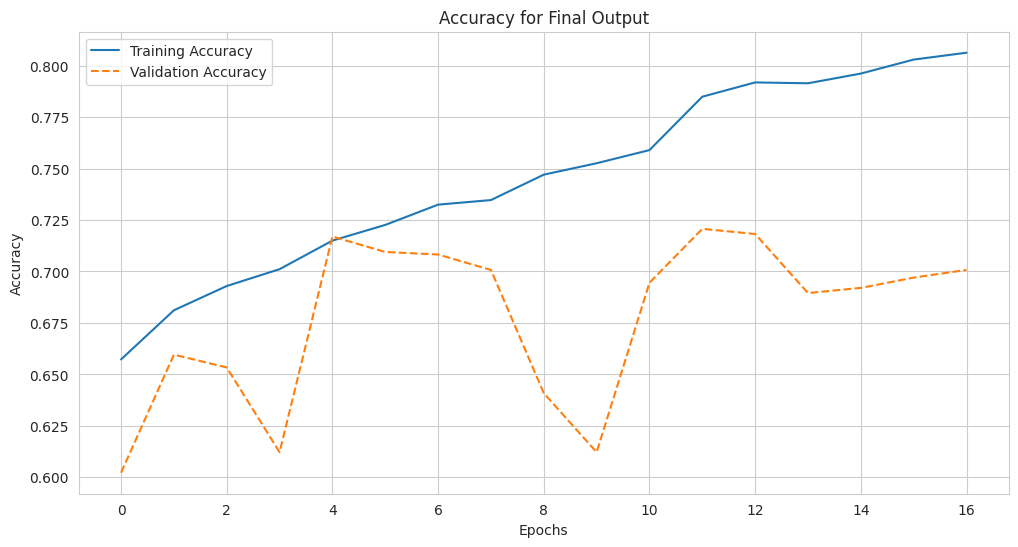

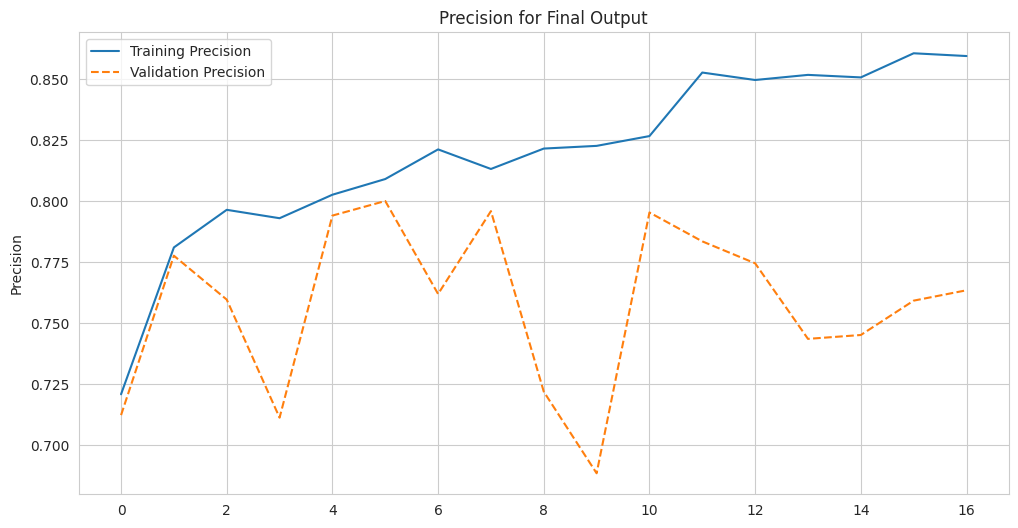

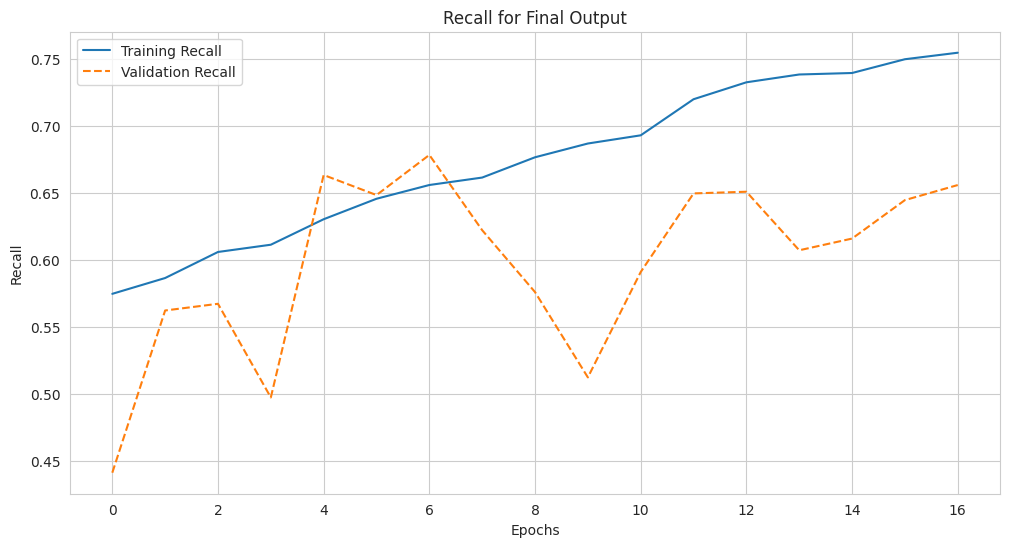

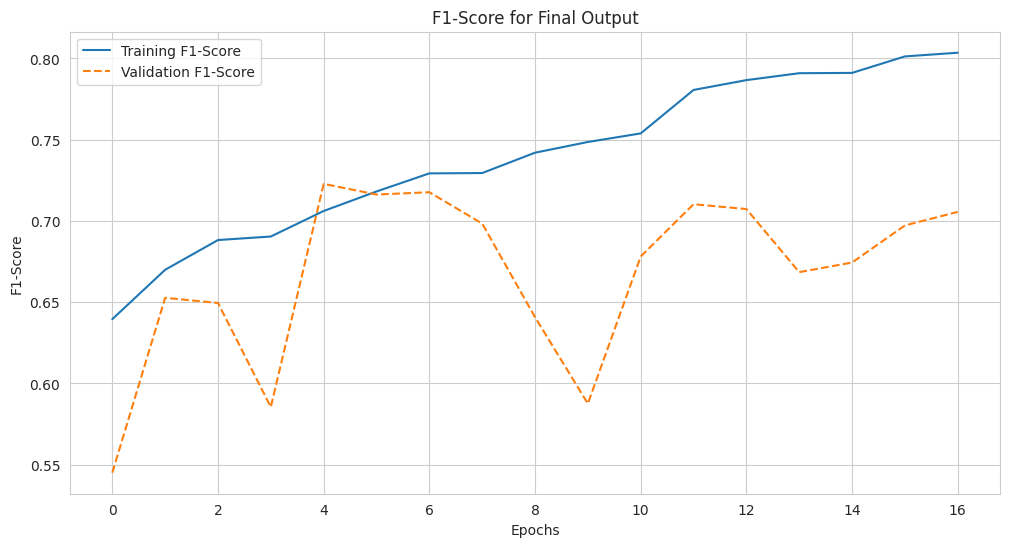

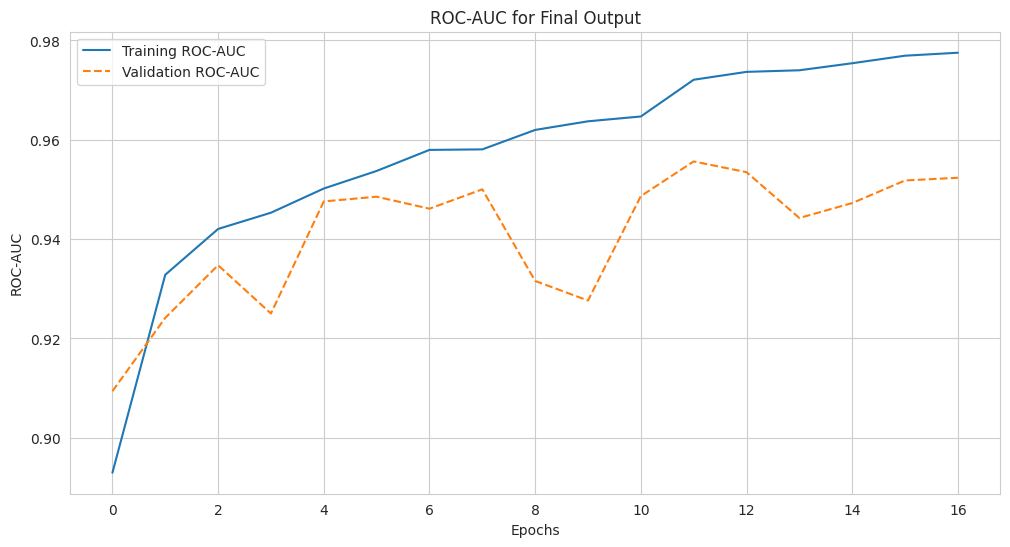

In [61]:
import matplotlib.pyplot as plt

# Extract training history
history_dict = history.history

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Total Training Loss')
plt.plot(history_dict['val_loss'], label='Total Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation Accuracy for final output
plt.figure(figsize=(12, 6))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for Final Output')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision for final output
plt.figure(figsize=(12, 6))
plt.plot(history_dict['precision'], label='Training Precision')
plt.plot(history_dict['val_precision'], label='Validation Precision', linestyle='--')
plt.ylabel('Precision')
plt.title('Precision for Final Output')
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall for final output
plt.figure(figsize=(12, 6))
plt.plot(history_dict['recall'], label='Training Recall')
plt.plot(history_dict['val_recall'], label='Validation Recall', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall for Final Output')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1-Score for final output
plt.figure(figsize=(12, 6))
plt.plot(history_dict['f1_score'], label='Training F1-Score')
plt.plot(history_dict['val_f1_score'], label='Validation F1-Score', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('F1-Score for Final Output')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC-AUC for final output
plt.figure(figsize=(12, 6))
plt.plot(history_dict['roc_auc'], label='Training ROC-AUC')
plt.plot(history_dict['val_roc_auc'], label='Validation ROC-AUC', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC for Final Output')
plt.legend()
plt.grid(True)
plt.show()


In [62]:
# Evaluate the student model
evaluation_results = EANet.evaluate(
    x_test,  # Test inputs
    y_test,  # Target labels for the final output
    verbose=1
)

# Optionally, print the results
print(f"Test Loss: {evaluation_results[0]}")
print(f"Test Accuracy: {evaluation_results[1]}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7190 - f1_score: 0.7200 - loss: 0.7072 - precision: 0.7971 - recall: 0.6566 - roc_auc: 0.9579
Test Loss: 0.7131232023239136
Test Accuracy: 0.7189216017723083


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step


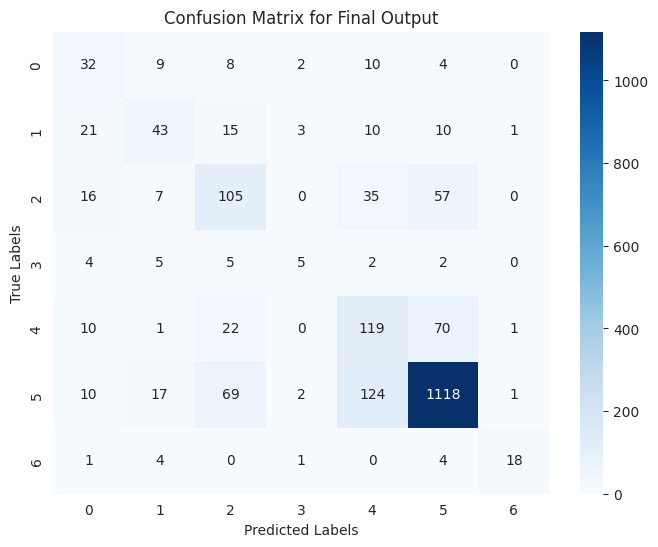

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the test dataset
predictions = EANet.predict(x_test, verbose=1)

# Use the final output predictions (only one output now)
y_pred_final = predictions  # Only one output, so we use the full predictions array
y_pred_classes = np.argmax(y_pred_final, axis=-1)  # Convert probabilities to class indices

# True labels for final output
y_true_final = np.argmax(y_test, axis=-1)  # Assuming y_test is one-hot encoded

# Generate confusion matrix
cm = confusion_matrix(y_true_final, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(cm.shape[1]), 
            yticklabels=np.arange(cm.shape[0]))
plt.title('Confusion Matrix for Final Output')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()